In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [200]:
save_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/risk_management/"
file_name = "2024_predictions_win_only.csv"
file_path = save_path + file_name
df = pd.read_csv(file_path, index_col=0)

folder_path = "/Users/benjamincheng/Documents/GitHub/Sports-Betting/data/odds_data/2021_01_20_onward.csv"
odds = pd.read_csv(folder_path, index_col=0)

In [201]:
odds

,Timestamp,Teams_x,Fanduel_odds_x,Draftkings_odds_x,BetMGM_odds_x,Teams_y,Fanduel_odds_y,Draftkings_odds_y,BetMGM_odds_y
0,2021-01-20,HOU,2.88,2.88,2.90,PHO,1.44,1.43,1.40
1,2021-01-20,PHO,1.44,1.43,1.40,HOU,2.88,2.88,2.90
2,2021-01-20,MEM,1.86,1.89,2.00,POR,1.98,1.93,1.83
3,2021-01-20,POR,1.98,1.93,1.83,MEM,1.86,1.89,2.00
4,2021-01-20,GSW,1.86,1.88,1.83,SAS,1.98,1.94,2.00
...,...,...,...,...,...,...,...,...,...
7691,2024-03-20,POR,6.60,6.25,6.50,LAC,1.12,1.13,1.12
7692,2024-03-20,CLE,1.77,1.77,1.77,MIA,2.10,2.10,2.05
7693,2024-03-20,MIA,2.10,2.10,2.05,CLE,1.77,1.77,1.77
7694,2024-03-20,BOS,1.17,1.19,1.18,MIL,5.30,4.90,5.00


In [202]:
# saying that they will lose is the same as saying other team will win, need to bet on other team to win

In [203]:
max_odds_columns = odds.iloc[:, 2:5].idxmax(axis=1)
best_odds = []

for index,row in odds.iterrows():
    best_odds.append(row[max_odds_columns[index]])

max_odds = pd.DataFrame({
    'Date': odds['Timestamp'],
    'Teams': odds['Teams_x'],
    'Max_Odds': best_odds
})

final = pd.merge(df, max_odds, on=['Date', 'Teams'], how='left')
column_order = ['Date', 'Teams', 'Max_Odds', 'Probabilities','Predictions', 'Actual']
final = final[column_order]

In [204]:
def kelly(decimal_odds, P, shrinkage):
    # shrinkage is the percent we want to shrink bets to account for uncertanity
    B = decimal_odds - 1
    Q = 1 - P
    solution = (B*P - Q) / B
    solution = solution * (1 - shrinkage)
    return solution

In [209]:
final['Kelly'] = kelly(final['Max_Odds'], 0.718, 0.50)
#final['Probabilities']

In [210]:
complete = final[final['Kelly'] > 0].reset_index(drop=True)
complete

,Date,Teams,Max_Odds,Probabilities,Predictions,Actual,Kelly
0,2024-01-09,LAL,1.52,0.527675,1,1,0.087846
1,2024-01-02,GSW,1.68,0.518415,1,1,0.151647
2,2024-01-01,MIN,1.85,0.512567,1,0,0.193118
3,2024-01-01,DAL,1.65,0.518707,1,0,0.142077
4,2024-01-01,TOR,1.70,0.509154,1,1,0.157571
...,...,...,...,...,...,...,...
208,2024-02-29,BRK,1.83,0.521332,1,1,0.189120
209,2024-02-29,ORL,1.42,0.575998,1,1,0.023286
210,2024-02-28,DAL,1.68,0.517205,1,1,0.151647
211,2024-02-28,CLE,1.50,0.542293,1,0,0.077000


In [211]:
# something to investigate is using the sigmoid probabilites vs using the model's accuracy score
def backtest(initial, df):
    balance = initial
    pnl = []
    for index,row in df.iterrows():
        bet_amount = (row['Kelly']) * initial
        if row['Predictions'] == row['Actual']:
            profit = bet_amount * (row['Max_Odds'] - 1)
            balance += profit
            pnl.append(profit)
        else:
            balance -= bet_amount
            pnl.append(-bet_amount)
        
    periods = len(df)
    returns = pow((balance / initial), (1/periods)) - 1
    returns = round(returns, 4) * 100 
    plt.figure(figsize = (16,7))
    plt.plot(df['Date'], pnl, c='b')
    plt.xlabel('Time(d)', size=17)
    plt.ylabel('Profit and Loss($)', size=17)
    
    print('\n')
    print(f'The growth rate on each bet is {returns}%.')
    print(f'The final balance is ${balance}.')



The growth rate on each bet is 0.5700000000000001%.
The final balance is $3384.7122084622474.


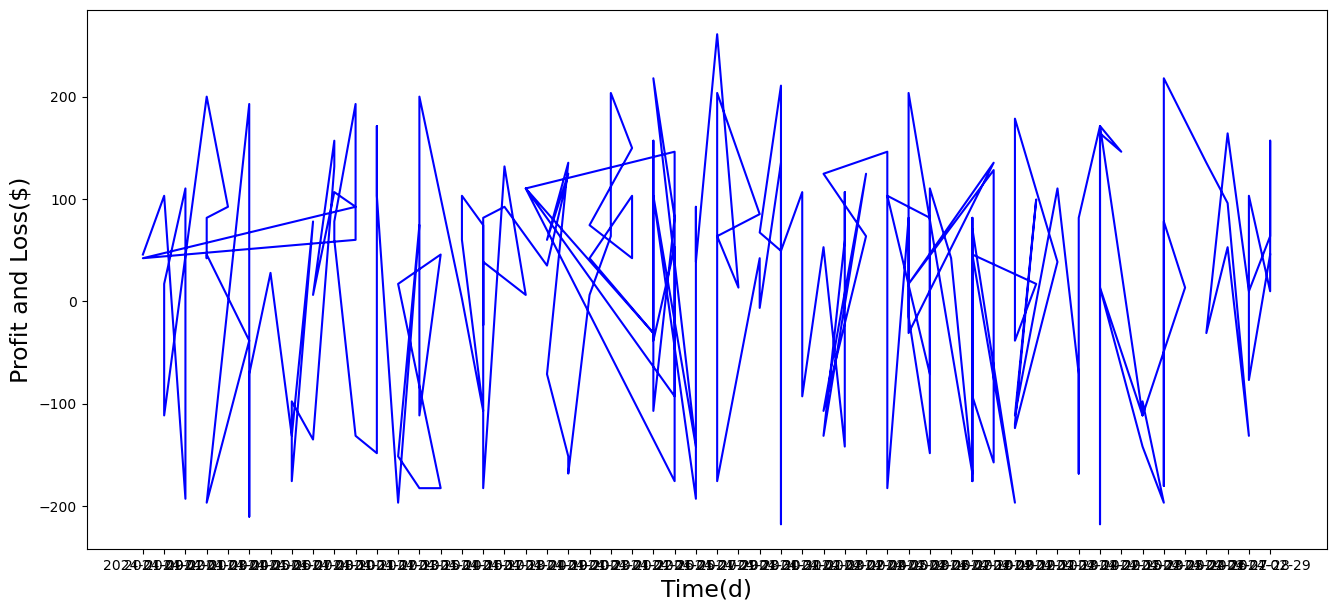

In [212]:
backtest(1000, complete)